In [1]:
n_threads = 6

In [2]:
import os
if n_threads is not None:
    os.environ["OMP_NUM_THREADS"] = str(n_threads)

sampling points for x emittance
0.8504349845061517
80
sampling points for y emittance
0.8498546846217544
130


/home/physics3/rroussel/SLAC_Xopt/tests/../scripts/characterize_emittance.py:621: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/home/physics3/rroussel/SLAC_Xopt/tests/../scripts/characterize_emittance.py:622: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)
/home/physics3/rroussel/SLAC_Xopt/tests/../scripts/characterize_emittance.py:621: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/home/physics3/rroussel/SLAC_Xopt/tests/../scripts/characterize_emi

10.318490505218506


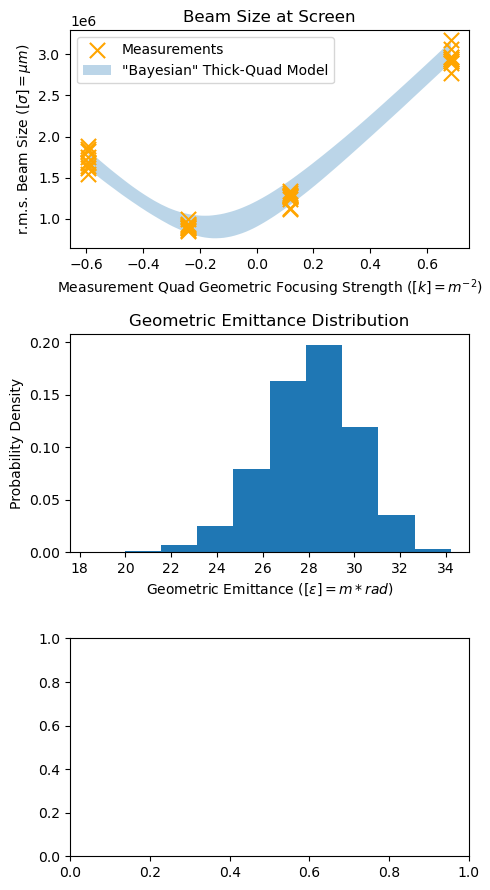

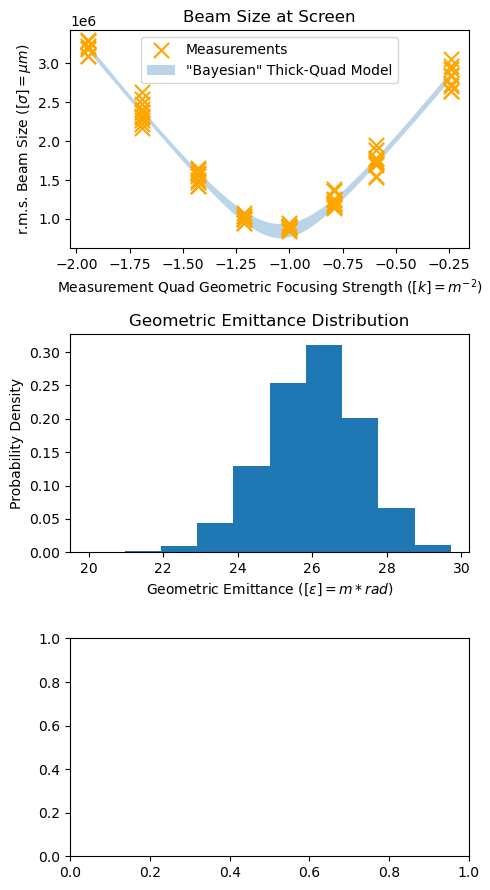

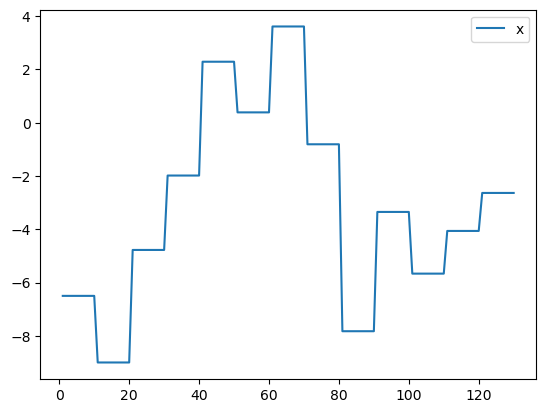

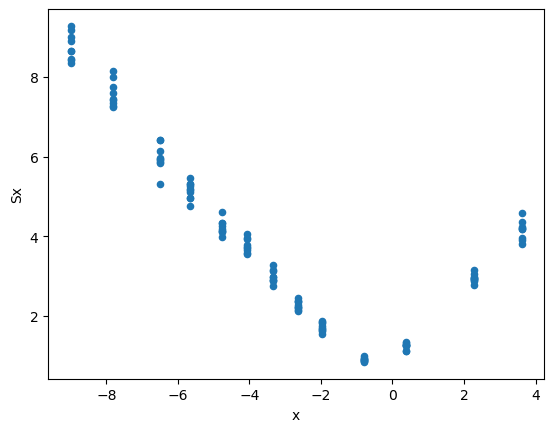

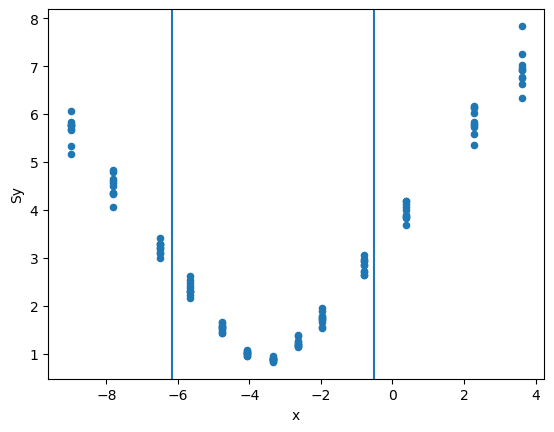

In [3]:
import sys
from time import time
from copy import deepcopy
sys.path.append("../")

from xopt import VOCS
from scripts.automatic_emittance import BaseEmittanceMeasurement, BeamlineConfig
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def test_beamsize_function(inputs):
    x = inputs["x"]
    y = x + 3
    sx = np.sqrt(x**2 + x + 1) * (1.0 + np.random.randn(10) * 0.05)
    sy = np.sqrt(y**2 + y + 1) * (1.0 + np.random.randn(10) * 0.05)

    if np.random.rand() > 0.5:
        sx[3] = np.NAN

    total_size = np.sqrt(np.array(sx) ** 2 + np.array(sy) ** 2)

    return {"Sx": sx, "Sy": sy, "total_size": total_size}


class TAutomaticEmittanceMeasurement(BaseEmittanceMeasurement):
    def eval_beamsize(self, inputs):
        results = test_beamsize_function(inputs)
        results["S_x_mm"] = results["Sx"]
        results["S_y_mm"] = results["Sy"]
        return results


    @property
    def base_vocs(self):
        vocs = VOCS(
            variables={
                self.beamline_config.scan_quad_pv: self.beamline_config.scan_quad_range
            },
            observables=["S_x_mm", "S_y_mm"],
        )

        return vocs

    @property
    def x_measurement_vocs(self):
        vocs = deepcopy(self.base_vocs) 
        vocs.objectives={"S_x_mm":"MINIMIZE"}

        return vocs

    @property
    def y_measurement_vocs(self):
        vocs = deepcopy(self.base_vocs)  
        vocs.objectives={"S_y_mm":"MINIMIZE"}

        return vocs

    def get_initial_points(self):
        return self.x_measurement_vocs.random_inputs(1)


beamline_config = BeamlineConfig(
    scan_quad_pv="x",
    scan_quad_range=[-10, 10],
    scan_quad_length=0.1,
    transport_matrix_x=[[1.0, 1.0], [0.0, 1.0]],
    transport_matrix_y=[[1.0, 1.0], [0.0, 1.0]],
    beam_energy=1.0,
)

emittance_measurement = TAutomaticEmittanceMeasurement(
    beamline_config=beamline_config,
    n_iterations=5,
    turbo_length=0.75,
    visualize=True,
)

start=time()
results, emit_x = emittance_measurement.run()
print(time() - start)

emit_x.data.plot(y="x")
ax = emit_x.data.plot.scatter(x="x", y="Sx")
ax = emit_x.data.plot.scatter(x="x", y="Sy")
tr = emit_x.generator.turbo_controller.get_trust_region(
    emit_x.generator.model
).flatten()
for ele in tr:
    ax.axvline(ele)

# emit_x.data.to_csv("test_data.csv")

os.remove(emittance_measurement.dump_file)
plt.show()